In [ ]:
pip install qiskit

In [ ]:
pip install pylatexenc

In [23]:
from sklearn import model_selection, datasets, svm
from qiskit import QuantumCircuit, Aer, IBMQ, QuantumRegister, ClassicalRegister
IBMQ.save_account('1fb65ee07e59b40aff552b4a399ab96366826d819c3daec88695245e30f77f518d1f2e3e899780baae0d972aa885bd1e871ce1c4000f864b7d76ab0360874d49')
import numpy as np
import qiskit
import copy
import matplotlib.pyplot as plt

In [3]:
iris = datasets.load_iris()
X = iris.data[0:100]
Y = iris.target[0:100]
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.33,random_state=42)

In [4]:
print(Y_train)

[0 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 1
 1 0 1 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 1]


In [5]:
print(X_train[0])
# there are 4 features

[5.2 3.4 1.4 0.2]


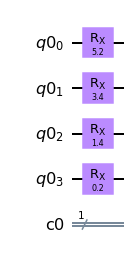

In [6]:
N = 4 # select qubit number as 4 as there are 4 features
q = QuantumRegister(N)
c = ClassicalRegister(1) # measurement will be written to this one classical register
qc = QuantumCircuit(q,c)

for i, x in enumerate(X_train[0]): #rotate the qubits as per the feature value
    qc.rx(x,i)
    
    
qc.draw('mpl')

In [7]:
# create a feature map method
def feature_map(X):
    q = QuantumRegister(N)
    c = ClassicalRegister(1)
    qc = QuantumCircuit(q,c)
    for i, x in enumerate(X):
        qc.rx(x,i)
    return qc, c

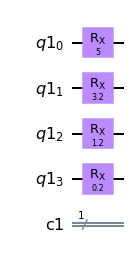

In [8]:
qc, c = feature_map(X_train[5])
qc.draw('mpl')

In [9]:
# create a variational circuit containing rotation angle Ry, 
# which then be optimized to get the
# desired output; prediction in this case
# eg. print(Y_train[5]) which is happened to be 0
def variational_circuit(qc, theta):
    for i in range(N-1):
        qc.cnot(i,i+1)
    qc.cnot(N-1, 0)  # CNOT gates for entanglement i.e transfer information from one qubit to another
    for i in range (N):
        qc.ry(theta[i],i)
    
    return qc

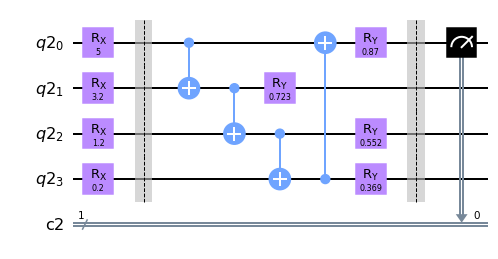

In [10]:
qc, c = feature_map(X_train[5])
qc.barrier()
qc = variational_circuit(qc, np.random.rand(N))
qc.barrier()
qc.measure(0,c)
qc.draw('mpl')


In [11]:
shots = 1E4 # run the circuit for 10,000 times
backend = Aer.get_backend('qasm_simulator')
job = qiskit.execute(qc,backend,shots=shots)
result = job.result()
counts = result.get_counts(qc)
print(counts)
print(counts['1']/shots)

# this circuit provides an output saying 65% probabaility that label for X_train[5] 
# i.e Y_train[5] is 1. However, the actual prediction is 0

{'0': 3863, '1': 6137}
0.6137


In [12]:
# creating a quantum NN function
def quantum_nn(X, theta, simulator=True):
    qc, c = feature_map(X)
    qc = variational_circuit(qc, theta)
    qc.measure(0,c)
    
    shots = 1E4
    backend = Aer.get_backend('qasm_simulator')
    if simulator == False:
        shots = 5000
        provider = IBMQ.load_account()
        backend = provider.get_backend('ibmq_manila')
    job = qiskit.execute(qc,backend,shots=shots)
    result = job.result()
    counts = result.get_counts(qc)
    
    return counts['1']/shots

In [15]:
# prediction probability of output to be 1
prediction = quantum_nn(X_train[5], np.random.rand(N))
print(prediction)

0.6781


In [14]:
target = Y_train[5]
print(target)

0


In [16]:
# loss function is squared error. when this is =0 then the prediction is correct

def loss(prediction, target):
    return (prediction-target)**2

In [17]:
def gradient(X, Y, theta):
    delta = 0.01
    grad = []
    for i in range (len(theta)):
        dtheta = copy.copy(theta)
        dtheta[i] += delta
        pred1 = quantum_nn(X, dtheta)
        pred2 = quantum_nn(X, theta)
        grad.append((loss(pred1,Y)-loss(pred2,Y))/delta)
    return np.array(grad)

In [18]:
def accuracy(X, Y, theta):
    counter = 0
    for X_i, Y_i in zip (X, Y):
        prediction = quantum_nn(X_i, theta)
        if prediction < 0.5 and Y_i == 0:
            counter +=1
        elif prediction >= 0.5 and Y_i ==1:
            counter +=1
    return counter/len(Y)

In [19]:
# the intention is to chnnage the theta value so as to minimize the loss 
eta = 0.05 # learning rate in SGD
loss_list = []
theta = np.ones(N)
print ('Epoch \t Loss \t Training Accuracy')
for i in range (20): # creating epochs
    loss_tmp = []
    for X_i, Y_i in zip(X_train, Y_train):
        prediction = quantum_nn(X_i, theta)
        loss_tmp.append(loss(prediction, Y_i))
        theta = theta - eta * gradient(X_i, Y_i, theta)
    
    loss_list.append(np.mean(loss_tmp)) # store the losses to check whether this is decreasing or not
    acc = accuracy(X_train, Y_train, theta)
    
    print(f'{i} \t {loss_list[-1]:.3f} \t {acc:.3f}')

Epoch 	 Loss 	 Training Accuracy
0 	 0.287 	 0.194
1 	 0.269 	 0.343
2 	 0.242 	 0.806
3 	 0.227 	 0.791
4 	 0.233 	 0.806
5 	 0.227 	 0.806
6 	 0.216 	 0.821
7 	 0.212 	 0.851
8 	 0.210 	 0.851
9 	 0.208 	 0.821
10 	 0.218 	 0.791
11 	 0.232 	 0.806
12 	 0.238 	 0.821
13 	 0.230 	 0.806
14 	 0.233 	 0.821
15 	 0.221 	 0.806
16 	 0.217 	 0.866
17 	 0.211 	 0.791
18 	 0.202 	 0.821
19 	 0.201 	 0.821


<function matplotlib.pyplot.show(close=None, block=None)>

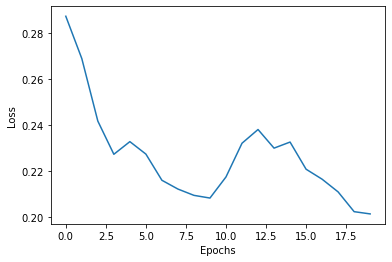

In [20]:
plt.plot(loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show

In [21]:
# check the accuracy for the test set
accuracy(X_test, Y_test, theta)

0.7878787878787878

In [24]:
# running the code in actual IBM quantum system
quantum_nn(X_test[6], theta, simulator=False)

0.3064

In [25]:
# running in the simulator
quantum_nn(X_test[6], theta)

0.2638